Collect & Import all the libraries once before coding

In [4]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random 
from sklearn.model_selection import train_test_split
import shutil
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## EDA och filhantering 

#### Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.


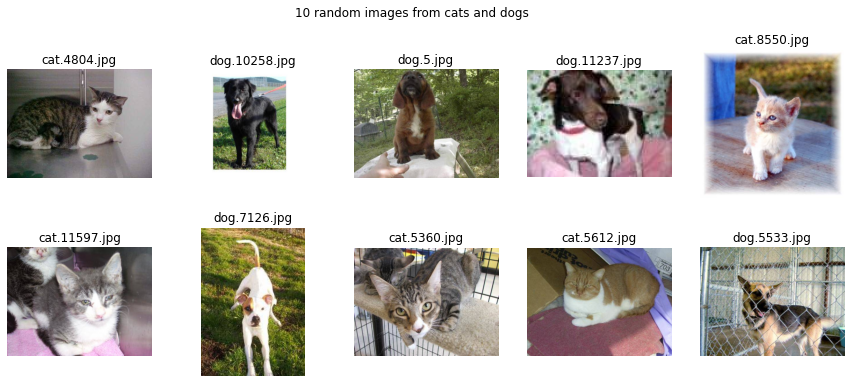

In [879]:
def plot_n_random_img(n, path):

    # Seclect sample images
    samples = random.sample(os.listdir(path), n)

    # loop the path for images
    path_images = [f"{path}/{file_name}" for file_name in samples]

    # read the images to array
    images_read = [plt.imread(file) for file in path_images]

    # Display the images with labels
    fig, axes = plt.subplots(2, int(n/2), figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images_read[i])
        ax.set_title(f"{samples[i]}")
        ax.axis("off")
    plt.suptitle(f"{n} random images from cats and dogs")

path = "../../Deep_learning/Lab/original_data/train/train"
plot_n_random_img(10, path)

#### Skapa folderstrukturen nedan med Python:

** I only show how to create dir(train/test) by coding. 

Create the dir (train/test) for small data:

In [182]:
# experiment_small_data = "../../Deep_learning/Lab/experiment_small_data"

# # For small train

# small_train_dir = os.path.join(experiment_small_data, "train")
# os.mkdir(small_train_dir)

# # For small test

# small_test_dir = os.path.join(experiment_small_data, "test")
# os.mkdir(small_test_dir)

# # For small val 

# small_val_dir = os.path.join(experiment_small_data, "val")
# os.mkdir(small_val_dir)

Create the dir (train/test) for tiny data:

In [183]:
# experiment_tiny_data = "../../Deep_learning/Lab/experiment_tiny_data"

# # For tiny train

# tiny_train_dir = os.path.join(experiment_tiny_data, "train")
# os.mkdir(tiny_train_dir)

# # For tiny test

# tiny_test_dir = os.path.join(experiment_tiny_data, "test")
# os.mkdir(tiny_test_dir)

# # For tiny val 

# tiny_val_dir = os.path.join(experiment_tiny_data, "val")
# os.mkdir(tiny_val_dir)

#### Nu ska göra train|val|test split med följande splits:

experiment_small:
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS):
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)



In [184]:
# Check how many train pics
train_img = os.listdir("../../Deep_learning/Lab/original_data/train/train")
len(train_img)

25000

Create a total name's pool for dogs and cats

In [236]:
train_cats = ["cat.{}.jpg".format(i) for i in random.sample(range(0, 12500), 12500)]
train_dogs = ["dog.{}.jpg".format(i) for i in random.sample(range(0, 12500), 12500)]

Original folder for img

In [240]:
original_dir = "../../Deep_learning/Lab/original_data/train/train"

Define a function for split

In [381]:
def train_val_test_split(n_train, n_val, n_test, path_train, path_val, path_test):

    # here randomly select n images from 1st-8000st, 8000st-10000st, 10000st-12500st for train, val and test. 
    # The purpose of this method is to select samples segmently and to avoid data leaking

    train_cat = random.sample(train_cats[0:8000], int(n_train/2))
    train_dog = random.sample(train_dogs[0:8000], int(n_train/2))

    val_cat = random.sample(train_cats[8000:10000], int(n_val/2))
    val_dog = random.sample(train_dogs[8000:10000], int(n_val/2))

    test_cat = random.sample(train_cats[10000:12500], int(n_test/2))
    test_dog = random.sample(train_dogs[10000:12500], int(n_test/2))

    for cats, dogs in zip(train_cat, train_dog):
        src = os.path.join(original_dir, cats)
        dst = os.path.join(path_train, cats)
        shutil.copyfile(src, dst)
        src = os.path.join(original_dir, dogs)
        dst = os.path.join(path_train, dogs)
        shutil.copyfile(src, dst)
            
    for cats, dogs in zip(val_cat, val_dog):
        src = os.path.join(original_dir, cats)
        dst = os.path.join(path_val, cats)
        shutil.copyfile(src, dst)
        src = os.path.join(original_dir, dogs)
        dst = os.path.join(path_val, dogs)
        shutil.copyfile(src, dst)

    for cats, dogs in zip(test_cat, test_dog):
        src = os.path.join(original_dir, cats)
        dst = os.path.join(path_test, cats)
        shutil.copyfile(src, dst)
        src = os.path.join(original_dir, dogs)
        dst = os.path.join(path_test, dogs)
        shutil.copyfile(src, dst)


For small data:

In [382]:
# small_train_dir ="../../Deep_learning/Lab/experiment_small_data/train"
# small_val_dir ="../../Deep_learning/Lab/experiment_small_data/val"
# small_test_dir ="../../Deep_learning/Lab/experiment_small_data/test"

# train_val_test_split(1600, 400 ,500, small_train_dir, small_val_dir, small_test_dir)


For tiny data:

In [383]:
# tiny_train_dir ="../../Deep_learning/Lab/experiment_tiny_data/train"
# tiny_val_dir ="../../Deep_learning/Lab/experiment_tiny_data/val"
# tiny_test_dir ="../../Deep_learning/Lab/experiment_tiny_data/test"

# train_val_test_split(160, 40 ,50, tiny_train_dir, tiny_val_dir, tiny_test_dir)

#### Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.

- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
- skapa lämplig plot för att kontrollera att dataseten är balanserade
- skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

Firstly create one-hot labels and randomize the data with function to avoid 0,0,0...1,1,1...

In [461]:
def randomize_and_one_hot(path):

    list = os.listdir(path)
    
    # shuffle the file names, mix the cat and dog images
    random.shuffle(list)

    images = [f"{path}/{file_name}" for file_name in list]

    y = []
    X = []
    
    for name in images:
      if "cat" in name:
        y.append(0)
      elif "dog" in name:
        y.append(1)
        
      X.append(cv2.imread(name))
  
    return X, y


Apply the function to small and tiny files

In [463]:
small_train_dir ="../../Deep_learning/Lab/experiment_small_data/train"
small_val_dir ="../../Deep_learning/Lab/experiment_small_data/val"
small_test_dir ="../../Deep_learning/Lab/experiment_small_data/test"

X_train_small, y_train_small = randomize_and_one_hot(small_train_dir)
X_val_small, y_val_small = randomize_and_one_hot(small_val_dir)
X_test_small, y_test_small = randomize_and_one_hot(small_test_dir)

tiny_train_dir ="../../Deep_learning/Lab/experiment_tiny_data/train"
tiny_val_dir ="../../Deep_learning/Lab/experiment_tiny_data/val"
tiny_test_dir ="../../Deep_learning/Lab/experiment_tiny_data/test"

X_train_tiny, y_train_tiny = randomize_and_one_hot(tiny_train_dir)
X_val_tiny, y_val_tiny = randomize_and_one_hot(tiny_val_dir)
X_test_tiny, y_test_tiny = randomize_and_one_hot(tiny_test_dir)

Plot the images

Text(0.5, 0.98, '10 cats and dogs images with 0/1 labels')

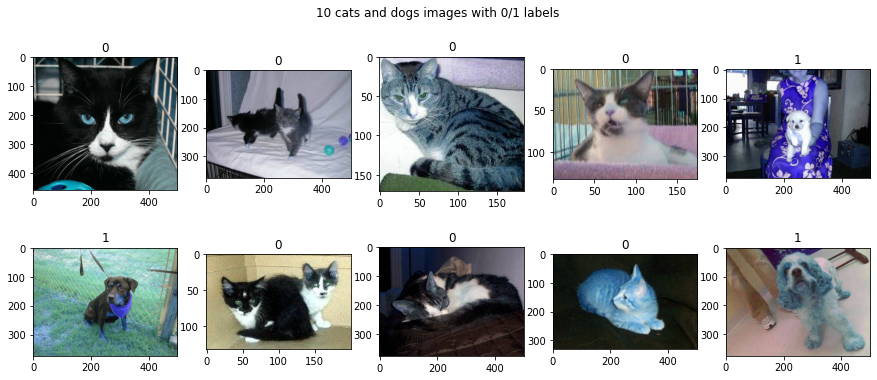

In [884]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train_tiny[i])
    ax.set_title(f"{y_train_tiny[i]}")
    ax.axis("on")
plt.suptitle("10 cats and dogs images with 0/1 labels")

Plot the balance of the datas

Text(0.5, 0.98, 'Number of Cats & dogs')

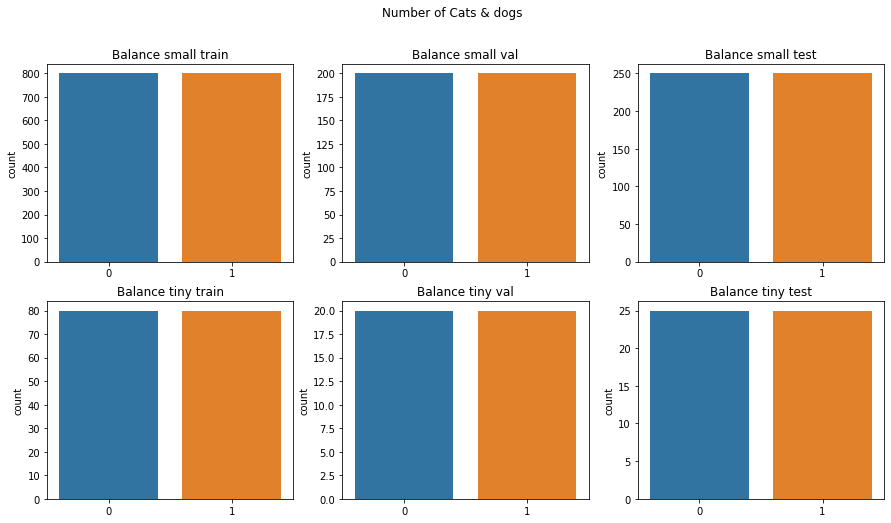

In [553]:
datas = [y_train_small, y_val_small, y_test_small, y_train_tiny, y_val_tiny, y_test_tiny]
titles = ["Balance small train", "Balance small val", 
          "Balance small test", "Balance tiny train", 
         "Balance tiny val","Balance tiny test",]

fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, data, title in zip(axes.flatten(), datas, titles):
    sns.countplot(x=data, ax=ax)
    ax.set(title = title)
    ax.axis("on")
plt.suptitle("Number of Cats & dogs")


From above we can see the same number of dog and cat in different data groups

Text(0.5, 0.98, 'Images distribution')

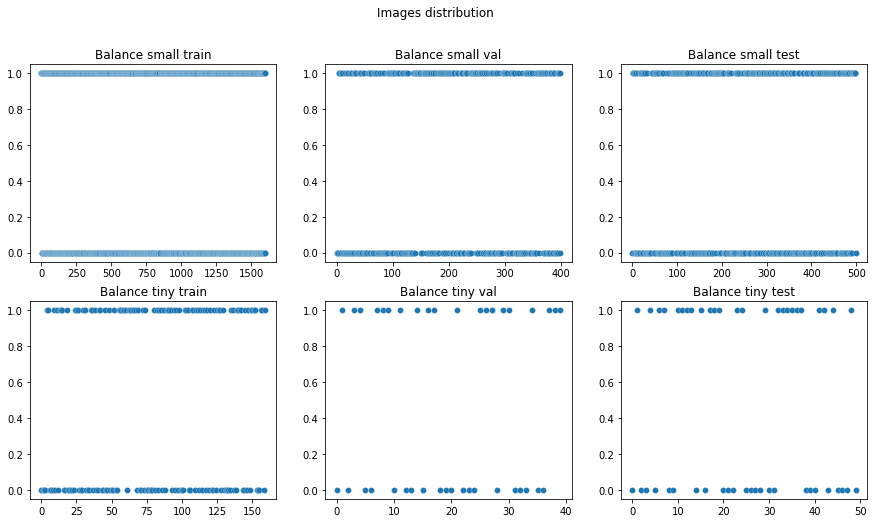

In [551]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax, data, title in zip(axes.flatten(), datas, titles):
    sns.scatterplot(data=data,linewidth=.2, ax=ax)
    ax.set(title = title)
    ax.axis("on")
plt.suptitle("Images distribution")

Here above the figure shows the dog and cat images are randomly distributed

# Bildbehandling

#### a) Skapa en plot för att visualisera bildstorlekarna i träningsdatan. Använd seaborns jointplot.

In [526]:
X_train_small[0].shape
# This is a image with 353*499(size) pixers

(353, 499, 3)

For small dataset

Text(0.5, 0.98, 'JointPlot for small train data')

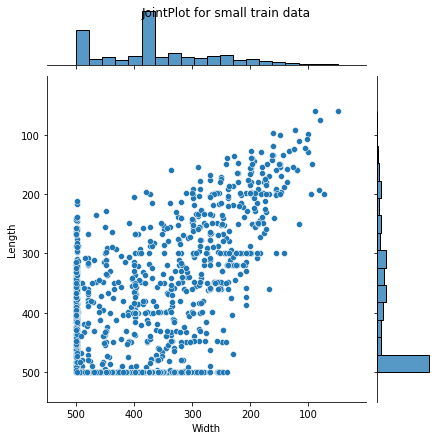

In [563]:
width_small = [X_train_small[i].shape[0] for i in range(len(X_train_small))]
length_small = [X_train_small[i].shape[1] for i in range(len(X_train_small))]

fig = sns.jointplot(x = width_small, y = length_small, xlim = 550, ylim = 550)
fig.set_axis_labels("Width", "Length")
plt.suptitle("JointPlot for small train data")

For tiny dataset

Text(0.5, 0.98, 'JointPlot for tiny train data')

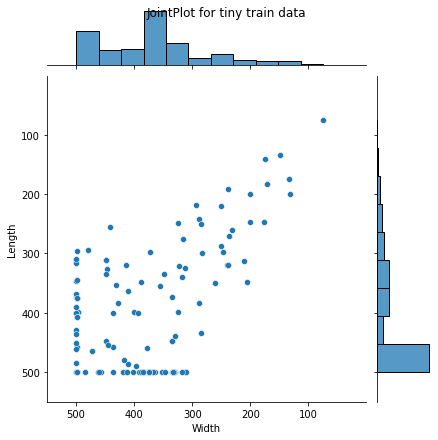

In [560]:
width_tiny = [X_train_tiny[i].shape[0] for i in range(len(X_train_tiny))]
length_tiny = [X_train_tiny[i].shape[1] for i in range(len(X_train_tiny))]

fig = sns.jointplot(x = width_tiny, y = length_tiny, xlim = 550, ylim = 550)
fig.set_axis_labels("Width", "Length")
plt.suptitle("JointPlot for tiny train data")

#### b) Välj en lämplig bildstorlek att ändra samtliga bilder till. Gör en analys och fundera på om du behöver slänga bilder. Hur kommer du fram till ditt val?

The images will have to be reshaped to modeling so that all images have the same shape. This is often a small square image. The image size defaults to keras is (256, 256) and we can use this setting in our case. Because cats/dogs images has a maximal size in 500 (width/length) and 256*256 can retain most of the information. (Maybe change to a smaller size if it running too slow)

Through the figure analysis of c), we can see that the image size in small/tiny are basically between 100 and 500. This means that the images basically retains the information we need. However, when we browse the images in folder with eyes, can also found very few images that are neither cats nor dogs (t.ex cat.5418). This may affect the accuracy. But due to the small number and the high workload of manual culling, I decided not to act.

#### c) Gör resize sådant att samtliga bilder är samma storlek och spara dem i numpy arrays med följande struktur:
<span style="color:grey">(samples, row, cols, color_channels)</span>.  


In [685]:
def resize(dataset):

	images_resized = []
	
	for data in dataset:
		
		resized = cv2.resize(data, (256, 256))
		images_resized.append(resized)
		
	images_resized = np.asarray(images_resized)
	
	return images_resized


In [687]:
X_train_small_resized = resize(X_train_small)
X_val_small_resized = resize(X_val_small)
X_test_small_resized = resize(X_test_small)

X_train_tiny_resized = resize(X_train_tiny)
X_val_tiny_resized = resize(X_val_tiny)
X_test_tiny_resized = resize(X_test_tiny)

X_train_small_resized.shape, X_train_tiny_resized.shape

((1600, 256, 256, 3), (160, 256, 256, 3))

#### Visualisera därefter ett par styckena bilder.

Text(0.5, 0.98, 'Resized images')

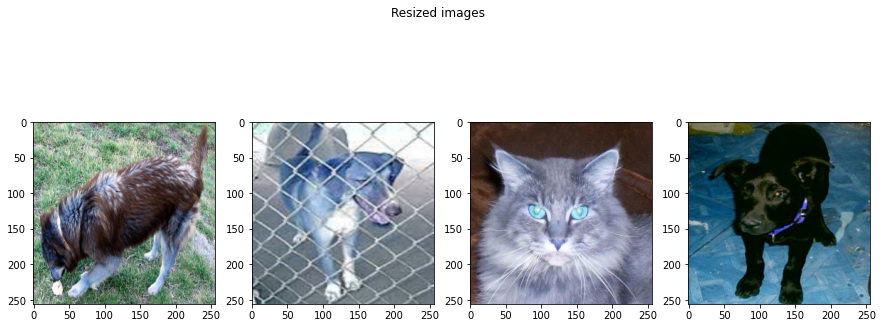

In [690]:
fig, axes = plt.subplots(1, 4, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train_small_resized[i])
    ax.axis("on")
plt.suptitle("Resized images")

#### d) Augmentera datan. Varför behövs dataaugmentering och hur beslutar vilka parametrar du valt för augmenteringen?


- When the amount of data is insufficient, the model is easy to overfit, and the accuracy can not improve. Therefore, data augmentation is needed. By using augmentation, it can automatically enhance training data.

- Here I decided to adjust the following three parameters:

(1) Color.  t.ex. "featurewise_center"

(2) Geometry.  t.ex. "shear_range"

(3) Bounding box.  t.ex. "width_shift_range"

In [688]:
scaled_X_train_small_resized = X_train_small_resized.astype("float32") / 255
scaled_X_val_small_resized = X_val_small_resized.astype("float32") / 255
scaled_X_test_small_resized = X_test_small_resized.astype("float32") / 255

scaled_X_train_tiny_resized = X_train_tiny_resized.astype("float32") / 255
scaled_X_val_tiny_resized = X_val_tiny_resized.astype("float32") / 255
scaled_X_test_tiny_resized = X_test_tiny_resized.astype("float32") / 255

In [691]:
train_image_generator  = ImageDataGenerator(
    rotation_range = 30,      # random rotation of the image. 40 degree
    width_shift_range = 0.2,  # is the extent to which the image is panned horizontally or vertically
    height_shift_range= 0.2,
    shear_range= 0.2,         # the angle of the random staggered transformation.
    zoom_range= 0.1,          # zoom in/zoom out
    horizontal_flip= True,    # reverse
    featurewise_center=True   # Color change
)

In [698]:
scaled_X_test_small_resized.shape

(500, 256, 256, 3)

In [761]:
# We generate only train data for small and tiny

train_small_generator = train_image_generator.flow(scaled_X_train_small_resized, y_train_small, batch_size=32)
test_small_generator = ImageDataGenerator()
val_small_generator = test_small_generator.flow(scaled_X_val_small_resized, y_val_small, batch_size=32)

train_tiny_generator = train_image_generator.flow(scaled_X_train_tiny_resized, y_train_tiny, batch_size=32)
test_tiny_generator = ImageDataGenerator()
val_tiny_generator = test_tiny_generator.flow(scaled_X_val_tiny_resized, y_val_tiny, batch_size=32)

For small data:

C:\Users\Kun\.virtualenvs\Deep-learning-AI21-mRD5Yo2b\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2
(32, 256, 256, 3)


Text(0.5, 0.98, 'Sample of augmentation')

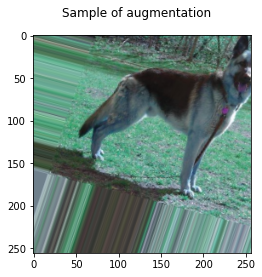

In [886]:
print(len(train_small_generator.next()))

sample_batch = train_small_generator.next()
print(sample_batch[0].shape) # 32 samples in a batch

plt.imshow(sample_batch[0][7])
plt.suptitle("Sample of augmentation")

# 2. Träna modeller (*)


#### För uppgifterna nedan, jobba med dataseten en åt gången:

Small

- utan augmenterig 
- med augmentering

Tiny (BONUS)

- utan augmentering
- med augmentering

#### a) Använd följande nätverk och träna på datan. Gör hyperparametertuning för några parametrar (beskriv hur du gör). Visualisera och analysera loss-kurvor, accuracy-kurvor.

In [793]:
def CNN_model(drop_rate, learning_rate):

  model = models.Sequential() 

  adam = Adam(learning_rate=learning_rate)
  
  # Biuld Conv2D and MaxPooling2D layers:
  # The depth of the feature map is increasing (from 32 to 128)
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3))) # same shape as we created
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2))) 
  model.add(Conv2D(128, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2))) 
  model.add(Conv2D(128, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2)))

  # connect to Flatten layer
  model.add(Flatten())
  model.add(Dropout(drop_rate)) # Dropout layer can reduce overfitting
  model.add(Dense(512, activation='relu')) 
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
  # using binary crossentropy here because of sigmoid function (binary labels)

  return model


model = CNN_model(0.5, 0.001)
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 30, 30, 128)    

Create a function for plot:

In [767]:
def plot_metrics(metrics):
    _, ax = plt.subplots(1,2, figsize = (12,4))
    metrics[["loss", "val_loss"]].plot(ax = ax[0], grid = True)
    metrics[["acc", "val_acc"]].plot(ax = ax[1], grid = True)

For tiny dataset without augmentation:

In [797]:
steps_per_epoch_tiny = int(len(scaled_X_train_tiny_resized)/32)
validation_steps_tiny = int(len(scaled_X_val_tiny_resized)/32)

steps_per_epoch_tiny, validation_steps_tiny

(5, 1)

In [762]:
test_tiny_generator_0 = ImageDataGenerator()
train_tiny_generator_0 = test_tiny_generator_0.flow(scaled_X_train_tiny_resized, y_train_tiny, batch_size=32)
val_tiny_generator_0 = test_tiny_generator_0.flow(scaled_X_val_tiny_resized, y_val_tiny, batch_size=32)

In [864]:
# Here choose "patience = 10, restore_best_weights = False"
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 10, restore_best_weights = False)

model.fit(
    train_tiny_generator_0,
    steps_per_epoch = steps_per_epoch_tiny,
    epochs = 50,
    callbacks = [early_stopper],
    validation_data = val_tiny_generator_0,
    validation_steps = validation_steps_tiny
)

Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 0.7002 - acc: 0.4938

TypeError: 'NoneType' object is not callable

In [772]:
metrics_tiny_without_augmentation = pd.DataFrame(model.history.history)
metrics_tiny_without_augmentation

,loss,acc,val_loss,val_acc
0,0.528281,0.81875,0.586964,0.56250
1,0.459996,0.81250,0.695486,0.56250
2,0.527714,0.73125,0.600853,0.56250
3,0.419335,0.86250,0.665126,0.56250
4,0.349952,0.81250,0.770562,0.62500
5,0.243796,0.88750,0.592318,0.68750
6,0.216034,0.91250,0.764927,0.71875
7,0.144862,0.94375,1.163388,0.59375
8,0.115620,0.94375,0.899965,0.68750
9,0.119922,0.96875,1.444431,0.59375


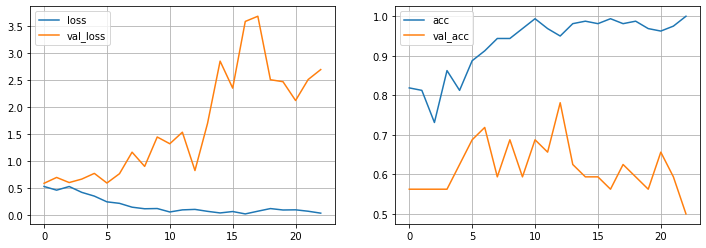

In [773]:
plot_metrics(metrics_tiny_without_augmentation)

For tiny data with augmentation:

In [856]:
# Here choose "patience = 5, restore_best_weights = True"
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = True)

model.fit(
    train_tiny_generator,
    steps_per_epoch = steps_per_epoch_tiny,
    epochs = 50,
    callbacks = [early_stopper],
    validation_data = val_tiny_generator,
    validation_steps = validation_steps_tiny
)

C:\Users\Kun\.virtualenvs\Deep-learning-AI21-mRD5Yo2b\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/50
5/5 [==============================] - ETA: 0s - loss: 1.3357 - acc: 0.5250

TypeError: 'NoneType' object is not callable

In [775]:
metrics_tiny = pd.DataFrame(model.history.history)
metrics_tiny

,loss,acc,val_loss,val_acc
0,1.144995,0.61250,0.684450,0.53125
1,0.712075,0.50000,0.690299,0.53125
2,0.690361,0.49375,0.708112,0.50000
3,0.708162,0.51875,0.696905,0.53125
4,0.693199,0.48750,0.685499,0.53125
5,0.690084,0.48750,0.703396,0.56250
6,0.673557,0.51250,0.714397,0.46875
7,0.663728,0.51875,0.718845,0.46875
8,0.695947,0.50000,0.714542,0.50000
9,0.677808,0.58750,0.724519,0.37500


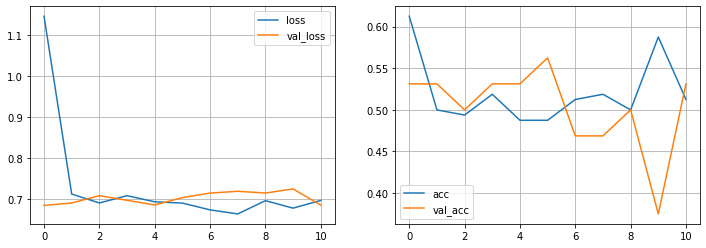

In [776]:
plot_metrics(metrics_tiny)

For small dataset without augmentation

In [780]:
steps_per_epoch_small = int(len(scaled_X_train_small_resized)/32)
validation_steps_small = int(len(scaled_X_val_small_resized)/32)

steps_per_epoch_small, validation_steps_small

(50, 12)

In [781]:
test_small_generator_0 = ImageDataGenerator()
train_small_generator_0 = test_small_generator_0.flow(scaled_X_train_small_resized, y_train_small, batch_size=32)
val_small_generator_0 = test_small_generator_0.flow(scaled_X_val_small_resized, y_val_small, batch_size=32)

In [782]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = False)

model.fit(
    train_small_generator_0,
    steps_per_epoch = steps_per_epoch_small,
    epochs = 20,
    callbacks = [early_stopper],
    validation_data = val_small_generator_0,
    validation_steps = validation_steps_small
)

Epoch 1/20
50/50 [==============================] - 175s 3s/step - loss: 0.6947 - acc: 0.4975 - val_loss: 0.7206 - val_acc: 0.5078
Epoch 2/20
50/50 [==============================] - 172s 3s/step - loss: 0.6942 - acc: 0.5200 - val_loss: 0.6840 - val_acc: 0.5443
Epoch 3/20
50/50 [==============================] - 164s 3s/step - loss: 0.6847 - acc: 0.5337 - val_loss: 0.6786 - val_acc: 0.5807
Epoch 4/20
50/50 [==============================] - 157s 3s/step - loss: 0.6779 - acc: 0.5481 - val_loss: 0.6856 - val_acc: 0.5391
Epoch 5/20
50/50 [==============================] - 171s 3s/step - loss: 0.6689 - acc: 0.5706 - val_loss: 0.6853 - val_acc: 0.5495
Epoch 6/20
50/50 [==============================] - 165s 3s/step - loss: 0.6577 - acc: 0.5800 - val_loss: 0.6727 - val_acc: 0.5911
Epoch 7/20
50/50 [==============================] - 169s 3s/step - loss: 0.6271 - acc: 0.6019 - val_loss: 0.6637 - val_acc: 0.5573
Epoch 8/20
50/50 [==============================] - 163s 3s/step - loss: 0.6006 - a

In [783]:
metrics_small_without_augmentation = pd.DataFrame(model.history.history)
metrics_small_without_augmentation

,loss,acc,val_loss,val_acc
0,0.694708,0.497500,0.720631,0.507812
1,0.694220,0.520000,0.684002,0.544271
2,0.684716,0.533750,0.678585,0.580729
3,0.677901,0.548125,0.685640,0.539062
4,0.668943,0.570625,0.685330,0.549479
5,0.657721,0.580000,0.672749,0.591146
6,0.627096,0.601875,0.663729,0.557292
7,0.600610,0.650000,0.677260,0.604167
8,0.569012,0.677500,0.703301,0.606771
9,0.537432,0.708125,0.721301,0.617188


Text(0.5, 0.98, 'Train/validation loss & Train/validation acc')

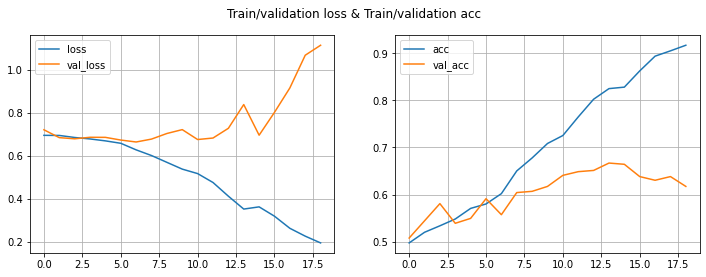

In [866]:
plot_metrics(metrics_small_without_augmentation)
plt.suptitle("Train/validation loss & Train/validation acc")

For small dataset with augmentation

In [785]:
early_stopper = EarlyStopping(monitor = "val_acc", mode = "max", patience = 5, restore_best_weights = False)

model.fit(
    train_small_generator,
    steps_per_epoch = steps_per_epoch_small,
    epochs = 20,
    callbacks = [early_stopper],
    validation_data = val_small_generator,
    validation_steps = validation_steps_small
)

C:\Users\Kun\.virtualenvs\Deep-learning-AI21-mRD5Yo2b\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/20
50/50 [==============================] - 185s 4s/step - loss: 0.8201 - acc: 0.5412 - val_loss: 0.6834 - val_acc: 0.5625
Epoch 2/20
50/50 [==============================] - 183s 4s/step - loss: 0.6714 - acc: 0.5931 - val_loss: 0.6513 - val_acc: 0.6146
Epoch 3/20
50/50 [==============================] - 180s 4s/step - loss: 0.6684 - acc: 0.5863 - val_loss: 0.6471 - val_acc: 0.6406
Epoch 4/20
50/50 [==============================] - 184s 4s/step - loss: 0.6643 - acc: 0.5987 - val_loss: 0.6415 - val_acc: 0.6458
Epoch 5/20
50/50 [==============================] - 179s 4s/step - loss: 0.6671 - acc: 0.5931 - val_loss: 0.6389 - val_acc: 0.6328
Epoch 6/20
50/50 [==============================] - 176s 4s/step - loss: 0.6598 - acc: 0.6119 - val_loss: 0.6449 - val_acc: 0.6276
Epoch 7/20
50/50 [==============================] - 176s 4s/step - loss: 0.6468 - acc: 0.6375 - val_loss: 0.6105 - val_acc: 0.7135
Epoch 8/20
50/50 [==============================] - 176s 4s/step - loss: 0.6500 - a

KeyError: "None of [Index(['loss', 'val_loss'], dtype='object')] are in the [columns]"

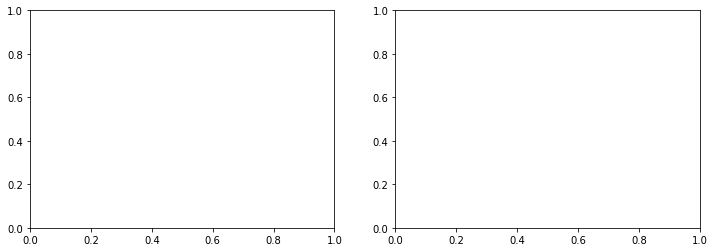

In [798]:
metrics_small = pd.DataFrame(model.history.history)
plot_metrics(metrics_small)

KeyError: "None of [Index(['loss', 'val_loss'], dtype='object')] are in the [columns]"

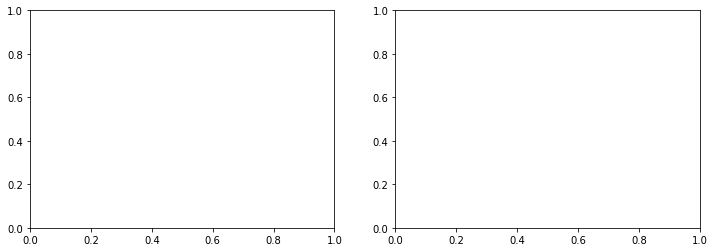

In [807]:
plot_metrics(metrics_small)

#### b) Förändra nätverket i a) experimentera och ändra i lite komponenter. Beskriv vad du ändrar och varför. Glöm inte att evaluera på valideringsdatan.


              precision    recall  f1-score   support

           0       0.50      1.00      0.67       250
           1       0.00      0.00      0.00       250

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weighted avg       0.25      0.50      0.33       500



C:\Users\Kun\.virtualenvs\Deep-learning-AI21-mRD5Yo2b\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kun\.virtualenvs\Deep-learning-AI21-mRD5Yo2b\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Kun\.virtualenvs\Deep-learning-AI21-mRD5Yo2b\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

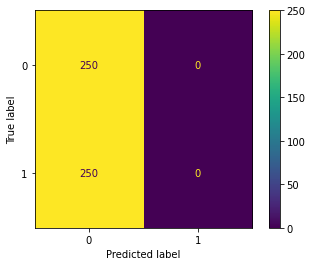

In [860]:
y_pred_small = model.predict(scaled_X_test_small_resized)
y_pred_small = ((y_pred_small > 0.5) + 0).ravel()
y_test_small = np.array(y_test_small)

print(classification_report(y_test_small, y_pred_small))
cm = confusion_matrix(y_test_small, y_pred_small)
ConfusionMatrixDisplay(cm).plot()

In [875]:
# model.evaluate(scaled_X_val_small_resized, y_val_small)

In [888]:
def CNN_model_2(drop_rate, learning_rate):

  model = models.Sequential() 

  adam = Adam(learning_rate=learning_rate)
  
  # Biuld Conv2D and MaxPooling2D layers:
  # The depth of the feature map is increasing (from 32 to 128)
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3))) # same shape as we created
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2))) 
  model.add(Conv2D(64, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2))) 
  model.add(Conv2D(128, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2))) 
  model.add(Conv2D(128, (3, 3), activation='relu')) 
  model.add(MaxPooling2D((2, 2))) 

  # connect to Flatten layer
  model.add(Flatten())
  model.add(Dropout(drop_rate)) # Dropout layer can reduce overfitting
  model.add(Dense(512, activation='relu')) 
  model.add(Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['acc'])
  # using binary crossentropy here because of sigmoid function (binary labels)

  return model


model_2 = CNN_model_2(0.5, 0.005)
model_2.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_63 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_62 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_65 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_64 (MaxPoolin  (None, 30, 30, 64)     

#### VGG16 summary:

- VGG16 is a model proposed by the Visual Geometry Group of Oxford University.
- VGG16 is characterized by proving that small convolutions can effectively improve performance by increasing the network depth.
- The default size of VGG16 for input images is 224 * 224 * 3. The VGG16 network structure has a total of 16 layers (with parameters), that is, 13 convolutional layers, 5 pooling layers(without parameters), and 3 fully connected layers, excluding the activation function(layers)
- conv3-64 means that the dimension becomes 64 after the third layer of convolution. Similarly, conv3-128 means that the dimension becomes 128 after the third layer of convolution
- FC-4096 refers to 4096 nodes in the fully connected layer, FC-1000 is a fully connected layer with 1000 nodes

|             Modules         | The layers of each module |
|-----------------------------|---------------------------|
|                Input images |             224 * 224 * 3     |
| | |
|||
|                 Module_1    |               **conv3-64**|
|                             |               **conv3-64**    |
|                             |               maxpool     |
|                 Module_2    |               **conv3-128**   |
|                             |               **conv3-128**   |
|                             |               maxpool     |
|                 Module_3    |               **conv3-256**   |
|                             |               **conv3-256**   |
|                             |               **conv3-256**   |
|                             |               maxpool     |
|                 Module_4    |               **conv3-512**   |
|                             |               **conv3-512**   |
|                             |               **conv3-512**   |
|                             |               maxpool     |
|                 Module_5    |               **conv3-512**   |
|                             |               **conv3-512**   |
|                             |               **conv3-512**   |
|                             |               maxpool     |
|      Module_6 (full connection layer and output layer)           |          (Flatten)         |
|                |          **FC-4096**          |
|                |          **FC-4096**          |
|                |          **FC-1000**  (classification)        |
|                |          softmax (Output function)          |

Process: 224 * 224 * 3 input: 
- conv1_1+conv1_2+pool_1：1st conv1, (3 * 3 * 3) * 64 = 1728(training parameters) --- 2st conv1（3 * 3 * 64） * 64=36864(training parameters); after maxpool(2 * 2), size: 112 * 112 * 64
- conv2_1+conv2_2+pool_2：after 2st conv2,（3 * 3 * 128） * 128=147456(training parameters); after maxpool, size: 56 * 56 * 128
- conv3_1+conv3_2+conv3_3+pool_3：after 3st conv3,（3 * 3 * 256） * 256=589824(training parameters); after maxpool, size: 28 * 28 * 256
- conv4_1+conv4_2+conv4_3+pool_4：after 3st conv4,（3 * 3 * 512） * 512=2359296(training parameters); after maxpool, size: 14 * 14 * 512
- conv5_1+conv5_2+conv5_3+pool_5：after 3st conv5,（3 * 3 * 512） * 512=2359296(training parameters); after maxpool, size: 7 * 7 * 512

In [5]:
from tensorflow.keras.applications import VGG16

input_shape = 224, 224, 3

base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(input_shape))

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
model_transfer = Sequential([
    base_model,
    Flatten(),
    Dropout(.5),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dropout(.5),
    Dense(1, activation="sigmoid")
], name = "Transfer_model")

for layer in base_model.layers:
    layer.trainable = False

model_transfer.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["acc"])

model_transfer.summary()

Model: "Transfer_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_2 (Dropout)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041

In [ ]:
model.fit(train_tiny_generator_0, epochs = 20, validation_data = val_tiny_generator_0)